In [123]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm

from utils.neural_network import train_nn, get_device

from models.KF import KF
from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [124]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [125]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [126]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cpu device


100%|██████████| 100/100 [00:02<00:00, 38.65it/s]


Final training loss: 0.01687462255358696
Final validation loss: 0.5011292695999146
Final validation R^2: 0.3338476794422509


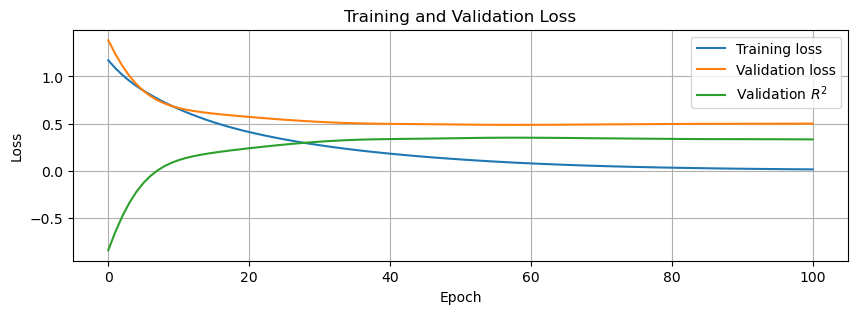

In [127]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

In [128]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [129]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [130]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country, predictions_melted=predictions_melted, verbose=False, file_name=None):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]

    plt.figure(figsize=(12, 6), dpi=300)

    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(loc='upper left', title="Legend", bbox_to_anchor=(1, 1))
    plt.grid(True)

    if verbose:
        plt.ylim([-4.75, 5]) # Set the y-axis limits (adapted to Switzerland)
        plt.xlim([datetime(2018, 1, 1), datetime(2025, 1, 1)]) # Show data from 2018 to 2025
        plt.savefig(results.OUTPUT_DATA_PATH + "{selected_country}.pdf" if file_name is None else results.OUTPUT_DATA_PATH + file_name, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(predictions_melted), verbose=widgets.fixed(False), file_name=widgets.fixed(None))

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Using the Kalman Filter on high frequency data

In [131]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [132]:
def apply_kalman_filter(model, preprocessor, use_true_values=False, seed=42, accurate_noise_var=None, accel_var=1e-5):
    # Based on true GDP data, to be used as low error measurements
    true_data = pd.DataFrame({
        'date': preprocessor.dates_train,
        'country': preprocessor.country_train,
        'pred': model(torch.tensor(preprocessor.X_train, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze(),
        'y': preprocessor.y_train,
    }).sort_values(by=['date', 'country']).reset_index(drop=True)

    # Remove the duplicates (due to data augmentation)
    true_data = true_data.drop_duplicates(subset=['date', 'country'], keep='first', ignore_index=True)

    # The measurements (high freq predictions) that we want to smooth
    hf_data = pd.DataFrame({
        'date': preprocessor.dates_high_freq,
        'country': preprocessor.country_high_freq,
        'y_pred': model(torch.tensor(preprocessor.x_high_freq, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze(),
        'Set': 'High Frequency',
    }).sort_values(by=['date', 'country']).reset_index(drop=True)

    # To store the smoothed results
    kf_data = hf_data.copy().assign(y_kf=np.nan)

    # Fit the Kalman filter on the true data (initializes initial state)
    kf = KF()
    kf.fit(true_data['pred'].values, true_data['y'].values, true_data['country'].values, accel_var=accel_var)

    for date in df_hf['date'].unique():
        mask = lambda df: df['date'] == date
        
        true_masked = true_data[mask(true_data)]

        nn_masked = hf_data[mask(hf_data)]
        # Keep only those for which we do not have accurate data
        nn_masked = nn_masked[~nn_masked['country'].isin(true_masked['country'])] if use_true_values else nn_masked

        if use_true_values and true_masked.shape[0] > 0:
            kf_predictions = kf.accurate_predict_update(y=true_masked['y'], countries=true_masked['country'], noise_var=accurate_noise_var)
            kf_data.loc[kf_data['country'].isin(true_masked['country']) & mask(kf_data), 'y_kf'] = kf_predictions
            
        if nn_masked.shape[0] > 0:
            kf_predictions = kf.predict_update(y=nn_masked['y_pred'], countries=nn_masked['country'])
            kf_data.loc[kf_data['country'].isin(nn_masked['country']) & mask(kf_data), 'y_kf'] = kf_predictions

    kf_predictions_melted = kf_data.melt(
        id_vars=["date", "country", "Set"],
        value_vars=["y_kf"], 
        var_name="Type", 
        value_name="Value"
    )

    hf_data_melted = hf_data.melt(
        id_vars=["date", "country", "Set"],
        value_vars=["y_pred"], 
        var_name="Type", 
        value_name="Value"
    )

    return kf_predictions_melted, hf_data_melted

kf_predictions_melted, hf_data_melted = apply_kalman_filter(model, preprocessor, use_true_values=False, seed=SEED, accurate_noise_var=0, accel_var=8e-6)

all_predictions_merged = pd.concat([predictions_melted[predictions_melted['Type'] != 'y_pred'], kf_predictions_melted, hf_data_melted], ignore_index=True)

# Create a dropdown widget for selecting the country
countries = all_predictions_merged["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)


means = results.measure_smoothness(all_predictions_merged[all_predictions_merged['Type'] == 'y_pred']['Value'].values, all_predictions_merged[all_predictions_merged['Type'] == 'y_pred']['date'], all_predictions_merged[all_predictions_merged['Type'] == 'y_pred']['country'])
print(f"Harmonic mean of smoothness metrics on preds: {means[1]}")

means = results.measure_smoothness(all_predictions_merged[all_predictions_merged['Type'] == 'y_kf']['Value'].values, all_predictions_merged[all_predictions_merged['Type'] == 'y_kf']['date'], all_predictions_merged[all_predictions_merged['Type'] == 'y_kf']['country'])
print(f"Harmonic mean of smoothness metrics on kf: {means[1]}")

means = results.measure_smoothness(all_predictions_merged[all_predictions_merged['Type'] == 'y_true']['Value'].values, all_predictions_merged[all_predictions_merged['Type'] == 'y_true']['date'], all_predictions_merged[all_predictions_merged['Type'] == 'y_true']['country'])
print(f"Harmonic mean of smoothness metrics on true: {means[1]}")


# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(all_predictions_merged), verbose=widgets.fixed(False), file_name=widgets.fixed(None))
plt.show()

Harmonic mean of smoothness metrics on preds: 0.636765182738523
Harmonic mean of smoothness metrics on kf: 0.24397213623921046
Harmonic mean of smoothness metrics on true: 0.7389002587478799


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [133]:
kf_predictions_melted_real_values, hf_data_melted_real_values = apply_kalman_filter(model, preprocessor, use_true_values=True, seed=SEED, accurate_noise_var=5e-4, accel_var=8e-6)

all_predictions_merged_real_values = pd.concat([predictions_melted[predictions_melted['Type'] != 'y_pred'], kf_predictions_melted_real_values, hf_data_melted_real_values], ignore_index=True)

# Create a dropdown widget for selecting the country
countries = all_predictions_merged_real_values["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

means = results.measure_smoothness(all_predictions_merged_real_values[all_predictions_merged_real_values['Type'] == 'y_kf']['Value'].values, all_predictions_merged_real_values[all_predictions_merged_real_values['Type'] == 'y_kf']['date'], all_predictions_merged_real_values[all_predictions_merged_real_values['Type'] == 'y_kf']['country'])
print(means[1])

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(all_predictions_merged_real_values), verbose=widgets.fixed(False), file_name=widgets.fixed(None))
plt.show()

0.4258177877922168


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Paper plot

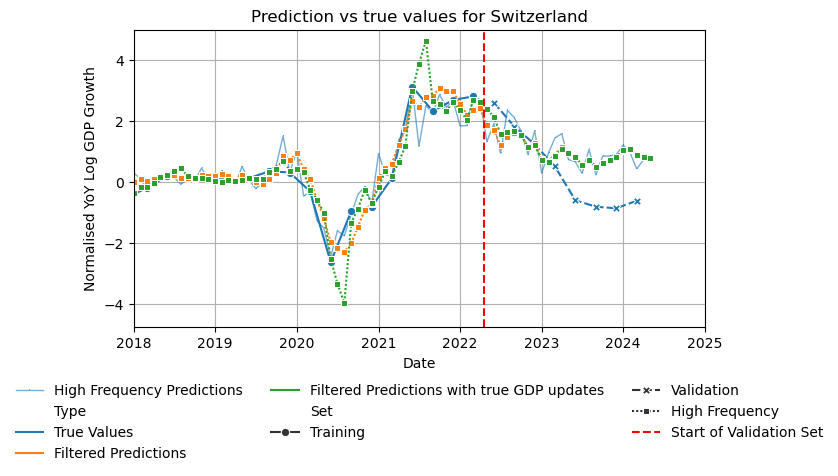

In [136]:
# Save the figures for Switzerland
#plt.style.use('ieee.mplstyle')

SELECTED_COUNTRY = 'Switzerland'

# Prepare the data
type_mapping = {
    'y_pred': 'Raw Predictions',
    'y_kf': 'Filtered Predictions',
    'y_true': 'True Values'
}

plot_data = all_predictions_merged.copy()
plot_data['Type'] = plot_data['Type'].apply(lambda x: type_mapping[x])
real_values = all_predictions_merged_real_values.loc[all_predictions_merged_real_values['Type'] == 'y_kf'].assign(Type='Filtered Predictions with true GDP updates')
plot_data = pd.concat([plot_data, real_values], ignore_index=True)

# Cutoff date
cutoff_date = (preprocessor.dates_valid.values[0] - preprocessor.dates_train.values[-1]) / 2 + preprocessor.dates_train.values[-1]

filtered_data = plot_data[(plot_data["country"] == SELECTED_COUNTRY) & (plot_data["Type"] != "Raw Predictions")]
high_freq_predictions = plot_data[(plot_data["country"] == SELECTED_COUNTRY) & (plot_data["Type"] == "Raw Predictions")]

plt.figure(figsize=(8, 5))

plt.plot(high_freq_predictions["date"], 
         high_freq_predictions["Value"],
         label="High Frequency Predictions",
         color="#1F77B4",
         linewidth=1,
         marker=',', 
         alpha=0.6)

sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)
plt.title(f"Prediction vs true values for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalised YoY Log GDP Growth")
plt.axvline(cutoff_date, color='red', linestyle='--', label='Start of Validation Set', linewidth=1.5)
plt.legend(
    loc="upper center",  # Position the legend in the center
    bbox_to_anchor=(0.5, -0.15),  # Center it below the plot
    ncol=3,  # Arrange items in a single row
    frameon=False  # Optional: Remove the legend frame
)
plt.grid(True)


plt.ylim([-4.75, 5]) # Set the y-axis limits (adapted to Switzerland)
plt.xlim([datetime(2018, 1, 1), datetime(2025, 1, 1)]) # Show data from 2018 to 2025
plt.savefig(results.OUTPUT_DATA_PATH + 'KF_Switzerland.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()